# Stage 3 Final Baseline: Attention‑Based MIL Model with Fixes

이 노트북은 Stage 2에서 생성한 MIL Bag 데이터를 입력으로 받아 어텐션 기반 MIL 모델을 학습하고 평가하는 최종 버전입니다. 


In [1]:
# 환경 설정
import os
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix
from tqdm import tqdm

# GPU 설정
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = os.getenv('MIL_STAGE3_GPU', '3')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('CUDA를 사용할 수 없습니다. CPU 모드로 실행됩니다.')

# 시드 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Using device: cuda
GPU: NVIDIA GeForce RTX 3090


In [2]:
# Stage 2 Bag 데이터 로드 및 Instance 평균 계산
embedding_margin = '0.4'
bags_dir = '/workspace/MIL/data/processed/bags'
train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_train.pkl')
val_pkl   = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_val.pkl')
test_pkl  = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_test.pkl')

print('Loading MIL bags...')
with open(train_pkl, 'rb') as f:
    train_data = pickle.load(f)
with open(val_pkl, 'rb') as f:
    val_data = pickle.load(f)
with open(test_pkl, 'rb') as f:
    test_data = pickle.load(f)

# Instance mean 계산: (10,5,256) → (10,256)
def to_instance_means(bags):
    return [bag.mean(axis=1).astype(np.float32) for bag in bags]

train_features = to_instance_means(train_data['bags'])
val_features   = to_instance_means(val_data['bags'])
test_features  = to_instance_means(test_data['bags'])

train_labels = train_data['labels']
val_labels   = val_data['labels']
test_labels  = test_data['labels']

print(f'Train bags: {len(train_labels)}, Val bags: {len(val_labels)}, Test bags: {len(test_labels)}')


Loading MIL bags...
Train bags: 3600, Val bags: 1200, Test bags: 1200


In [3]:
# Dataset 클래스 (on‑the‑fly Tensor 변환)

class MILDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features  # list of np.ndarray
        self.labels = labels      # list of int
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

batch_size = 16
train_loader = DataLoader(MILDataset(train_features, train_labels), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(MILDataset(val_features,   val_labels),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(MILDataset(test_features,  test_labels),  batch_size=batch_size, shuffle=False)


In [4]:
# 모델 정의 및 초기화 함수

class AttentionMIL(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.att_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.att_fc2 = nn.Linear(hidden_dim, 1)
        self.classifier = nn.Linear(hidden_dim, 1)
        self._init_weights()
    def _init_weights(self):
        # He initialization for layers followed by ReLU
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        nn.init.xavier_uniform_(self.att_fc1.weight)
        nn.init.zeros_(self.att_fc1.bias)
        nn.init.xavier_uniform_(self.att_fc2.weight)
        nn.init.zeros_(self.att_fc2.bias)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    def forward(self, x):
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)
        a = torch.tanh(self.att_fc1(h))
        a = self.att_fc2(a).squeeze(-1)
        weights = torch.softmax(a, dim=1)
        bag_repr = torch.sum(weights.unsqueeze(-1) * h, dim=1)
        bag_repr = self.dropout(bag_repr)
        logits = self.classifier(bag_repr).squeeze(-1)
        return logits, weights

class MeanPoolingModel(nn.Module):
    def __init__(self, input_dim=256):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    def forward(self, x):
        bag_mean = x.mean(dim=1)
        logits = self.fc(bag_mean).squeeze(-1)
        return logits

# 모델 인스턴스
mil_model = AttentionMIL(input_dim=256, hidden_dim=128, dropout_p=0.1).to(device)
base_model = MeanPoolingModel(input_dim=256).to(device)

# 손실 함수 및 최적화 기법
criterion = nn.BCEWithLogitsLoss()
optimizer_mil  = torch.optim.Adam(mil_model.parameters(), lr=1e-3)
optimizer_base = torch.optim.Adam(base_model.parameters(), lr=1e-3)
scheduler_mil  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_mil, mode='max', factor=0.5, patience=1, verbose=True)
scheduler_base = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_base, mode='max', factor=0.5, patience=1, verbose=True)


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# 학습 및 평가 함수 (Early Stopping)

def train_one_epoch(model, optimizer, loader):
    model.train()
    total_loss = 0.0
    preds_all = []
    labels_all = []
    for X, y in tqdm(loader, desc='Train', leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)[0] if isinstance(model, AttentionMIL) else model(X)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(y.cpu().numpy())
    return total_loss / len(loader.dataset), accuracy_score(labels_all, preds_all)

def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    probs_all = []
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for X, y in tqdm(loader, desc='Eval', leave=False):
            X, y = X.to(device), y.to(device)
            logits = model(X)[0] if isinstance(model, AttentionMIL) else model(X)
            loss = criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            probs_all.extend(probs.cpu().numpy())
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
    acc = accuracy_score(labels_all, preds_all)
    auc = roc_auc_score(labels_all, probs_all) if len(set(labels_all)) > 1 else 0.0
    f1 = f1_score(labels_all, preds_all) if len(set(preds_all)) > 1 else 0.0
    return total_loss / len(loader.dataset), acc, auc, f1, np.array(probs_all), np.array(labels_all), np.array(preds_all)

def train_model(model, optimizer, scheduler, train_loader, val_loader, max_epochs=10, patience=3, name='model'):
    best_auc = 0.0
    best_state = None
    epochs_no_improve = 0
    for epoch in range(1, max_epochs+1):
        print(f"\nEpoch {epoch}/{max_epochs} – {name}")
        tr_loss, tr_acc = train_one_epoch(model, optimizer, train_loader)
        val_loss, val_acc, val_auc, val_f1, _, _, _ = evaluate(model, val_loader)
        print(f"  Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}, F1: {val_f1:.4f}")
        scheduler.step(val_auc)
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, f'best_{name}.pth')
            print(f"  ✅ New best AUC: {best_auc:.4f} – model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  No improvement. Patience: {epochs_no_improve}/{patience}")
            if epochs_no_improve >= patience:
                print("  🛑 Early stopping triggered.")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10 – attention_mil_final


  Train Loss: 1.1233, Acc: 0.4997
  Val   Loss: 1.0858, Acc: 0.5000, AUC: 0.7346, F1: 0.0000
  ✅ New best AUC: 0.7346 – model saved.

Epoch 2/10 – attention_mil_final


  Train Loss: 1.0375, Acc: 0.5000
  Val   Loss: 1.0360, Acc: 0.5000, AUC: 0.7932, F1: 0.0000
  ✅ New best AUC: 0.7932 – model saved.

Epoch 3/10 – attention_mil_final


  Train Loss: 0.9777, Acc: 0.5000
  Val   Loss: 0.9956, Acc: 0.5000, AUC: 0.8036, F1: 0.0000
  ✅ New best AUC: 0.8036 – model saved.

Epoch 4/10 – attention_mil_final


  Train Loss: 0.9403, Acc: 0.5022
  Val   Loss: 0.9882, Acc: 0.5075, AUC: 0.8164, F1: 0.0327
  ✅ New best AUC: 0.8164 – model saved.

Epoch 5/10 – attention_mil_final


  Train Loss: 0.9019, Acc: 0.5272
  Val   Loss: 0.9591, Acc: 0.5408, AUC: 0.8145, F1: 0.1764
  No improvement. Patience: 1/3

Epoch 6/10 – attention_mil_final


  Train Loss: 0.8654, Acc: 0.5747
  Val   Loss: 0.9535, Acc: 0.6317, AUC: 0.8147, F1: 0.4662
  No improvement. Patience: 2/3

Epoch 7/10 – attention_mil_final


  Train Loss: 0.8221, Acc: 0.6236
  Val   Loss: 0.9715, Acc: 0.6958, AUC: 0.8199, F1: 0.6186
  ✅ New best AUC: 0.8199 – model saved.

Epoch 8/10 – attention_mil_final


  Train Loss: 0.7914, Acc: 0.6497
  Val   Loss: 0.9647, Acc: 0.7200, AUC: 0.8227, F1: 0.6647
  ✅ New best AUC: 0.8227 – model saved.

Epoch 9/10 – attention_mil_final


  Train Loss: 0.7636, Acc: 0.6794
  Val   Loss: 0.9649, Acc: 0.7358, AUC: 0.8224, F1: 0.6972
  No improvement. Patience: 1/3

Epoch 10/10 – attention_mil_final


  Train Loss: 0.7329, Acc: 0.7086
  Val   Loss: 0.9942, Acc: 0.7500, AUC: 0.8200, F1: 0.7292
  No improvement. Patience: 2/3


Best validation F1 threshold: 0.350 (F1=0.764)
Final test metrics (Weighted BCE + optimised threshold):
  Accuracy: 0.719, F1: 0.759, Precision: 0.665, Recall: 0.885, AUC: 0.829


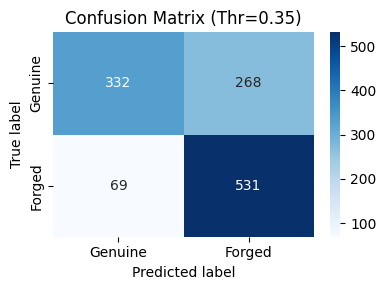

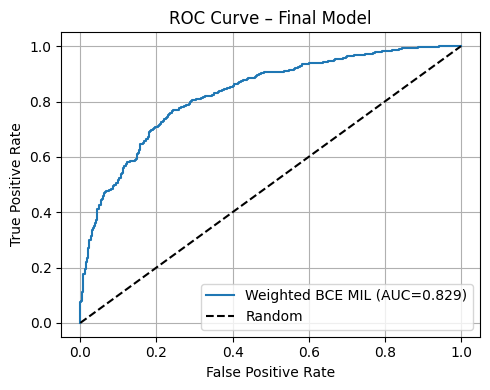

In [6]:

# ==============================================================================
# Final Pipeline: Weighted BCE training with validation‑based threshold search
#
# 이 셀은 가중 BCE(음성 클래스 FP 가중치 2.0)를 이용해 MIL 모델을 학습하고,
# validation 세트에서 F1 기준으로 최적 threshold를 찾아 테스트 성능을 산출합니다.
# 또한 Confusion Matrix와 ROC 곡선 시각화를 제공합니다.

import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix

# Define Weighted BCE loss
class WeightedBCE(nn.Module):
    def __init__(self, fp_weight=2.0):
        super().__init__()
        self.fp_weight = fp_weight
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, logits, labels):
        loss = self.bce(logits, labels)
        fp_mask = (labels == 0).float()
        loss = loss * (1 + self.fp_weight * fp_mask)
        return loss.mean()

# Use Weighted BCE as the criterion for the final model
criterion = WeightedBCE(fp_weight=2.0)

# Initialise a fresh MIL model
mil_model_final = AttentionMIL(input_dim=256, hidden_dim=128, dropout_p=0.1).to(device)
optimizer_final = torch.optim.Adam(mil_model_final.parameters(), lr=1e-3)
scheduler_final = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_final, mode='max', factor=0.5, patience=1, verbose=True
)

# Train the model
mil_model_final = train_model(
    mil_model_final, optimizer_final, scheduler_final,
    train_loader, val_loader, max_epochs=10, patience=3, name='attention_mil_final'
)

# Evaluate on validation and test
val_loss_final, val_acc_final, val_auc_final, val_f1_final, val_probs_final, val_labels_final, _ = evaluate(
    mil_model_final, val_loader
)
test_loss_final, test_acc_final, test_auc_final, test_f1_final, test_probs_final, test_labels_final, _ = evaluate(
    mil_model_final, test_loader
)

# Function to find best threshold based on F1
def find_best_threshold(probs, labels):
    best_thr, best_val = 0.5, 0.0
    for thr in np.linspace(0.05, 0.95, 37):
        preds = (probs >= thr).astype(int)
        val = f1_score(labels, preds, zero_division=0)
        if val > best_val:
            best_val, best_thr = val, thr
    return best_thr, best_val

# Determine the best threshold on validation set
best_thr_final, best_f1_valid = find_best_threshold(val_probs_final, val_labels_final)
print(f'Best validation F1 threshold: {best_thr_final:.3f} (F1={best_f1_valid:.3f})')

# Apply the threshold to test set
test_preds_adj_final = (test_probs_final >= best_thr_final).astype(int)
acc_final = accuracy_score(test_labels_final, test_preds_adj_final)
f1_final = f1_score(test_labels_final, test_preds_adj_final, zero_division=0)
prec_final = precision_score(test_labels_final, test_preds_adj_final, zero_division=0)
recall_final = recall_score(test_labels_final, test_preds_adj_final, zero_division=0)
print('Final test metrics (Weighted BCE + optimised threshold):')
print(f'  Accuracy: {acc_final:.3f}, F1: {f1_final:.3f}, Precision: {prec_final:.3f}, Recall: {recall_final:.3f}, AUC: {test_auc_final:.3f}')

# Confusion matrix
cm_final = confusion_matrix(test_labels_final.astype(int), test_preds_adj_final.astype(int), labels=[0,1])
plt.figure(figsize=(4,3))
sns.heatmap(
    cm_final, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Genuine','Forged'], yticklabels=['Genuine','Forged']
)
plt.title(f'Confusion Matrix (Thr={best_thr_final:.2f})')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# ROC curve
fpr_final, tpr_final, _ = roc_curve(test_labels_final, test_probs_final)
auc_final_value = auc(fpr_final, tpr_final)
plt.figure(figsize=(5,4))
plt.plot(fpr_final, tpr_final, label=f'Weighted BCE MIL (AUC={auc_final_value:.3f})')
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Final Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
